### Horizontal Gradient Estimates for Velocity, Density, Buoyancy, Temperature, and Salinity Using Saildrone Data from EUREC4A / ATOMIC

Description: This notebook estimates submesoscale horizontal gradients of several variables using saildrone data collected during the EUREC4A / ATMOIC campaign which took place in winter 2020 in the northwest Tropcial Atlantic. Horizontal gradients are estimated via a least squares approximation. Three saildrones are used in the approximation, and the calculation is only done when the relative distance between drones is 5km or less. Additionally, it is required to have at least three data points per drone in each calculation - if this condiditon is not met then 'nan' is returned for the approximation. The approximation is done in 30 minute interals, centered around the respective data point. 

### Questions that I have: 

- does it really matter if I don't use conservative temperature and absolute salinity to calculate potential density since all of my data is at the surface? If it does matter, should I assume my pressure is 0 dbar in the conservative temp / absolute salinity calculations? 

- I need to change my gravity constant value - should be 9.81 m/s^s, is there a constant for gravity that I could use in gsw package?

- In calculating buoyancy, should I always use 1025 as reference density (rho_0) or should this change based on what the mean density is for my situation. Should I be setting rho_0 to be the mean density in the saildrone data????

- There are some intervals for the gradient calculation that have very small distance covered (sometimes as small as 0.02 km), this is likely because the saildrones are not moving. This shouldn't matter for our gradient calculations? The only thing we really need to be concerned about is distance between saildrones? 

#### 1. Import Packages 

In [1]:
# for local use 

# import utilities (functions I created) 
import sys
sys.path.append("/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/utilities")
from Utils import *
from ATOMIC_Utils import *
from Gradient_LeastSquares import *

# import python packages 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import datetime
import pandas as pd
import gsw
import seawater as sw
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import nan_euclidean_distances
from scipy import stats
from pycurrents.adcp.rdiraw import Multiread
import gsw_xarray as gsw

### Define some functions 

In [2]:
def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3,color='k',zorder=1,size=14):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1] 

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, linewidth=linewidth,color=color,zorder=zorder)
    #Plot the scalebar label
    ax.text(sbx, sby+9000, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom',color=color,zorder=zorder,size=size)


In [3]:

def CalculateDistance(lon,lat):
    """
    Calculate along-track distance given
        an array of lon,lat.
    Return
        - along-track distance [km]
    """
    return np.hstack([0,np.cumsum(sw.dist(lon=lon,lat=lat,units='km')[0])])

#### 2. Load Saildrone Data from PO.DAAC and save locally for easy loading later

##### Access earthaccess for getting the saildrone data 

In [6]:
import earthaccess
earthaccess.__version__

/opt/anaconda3/envs/oceandynamics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'0.8.2'

In [7]:
from earthaccess import Auth, Store, DataCollections, DataGranules
auth = Auth()

In [9]:
# must enter credentials 
auth.login(strategy="interactive", persist=True)

Enter your Earthdata Login username:  mac2307
Enter your Earthdata password:  ········


Persisting credentials to .netrc


In [10]:
auth.login(strategy="netrc")
# are we authenticated?
print(auth.authenticated)

True


##### Search for the saildrone data using shortname 

In [11]:
from pprint import pprint
Query = DataGranules().short_name('SAILDRONE_ATOMIC')

In [12]:
granules = Query.get()

In [13]:
data_links = [{'links': g.data_links(access="on_prem"), 'size (MB):': g.size()} for g in granules]
data_links

[{'links': ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SAILDRONE_ATOMIC/saildrone-gen_5-atomic_eurec4a_2020-sd1026-20200117T000000-20200302T235959-5_minutes-v1.1595997001389.nc'],
  'size (MB):': 79.23225116729736},
 {'links': ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SAILDRONE_ATOMIC/saildrone-gen_5-atomic_eurec4a_2020-sd1061-20200117T000000-20200302T235959-5_minutes-v1.1595997706709.nc'],
  'size (MB):': 79.23225116729736},
 {'links': ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SAILDRONE_ATOMIC/saildrone-gen_5-atomic_eurec4a_2020-sd1060-20200117T000000-20200302T235959-5_minutes-v1.1595997115384.nc'],
  'size (MB):': 79.23225116729736},
 {'links': ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SAILDRONE_ATOMIC/saildrone-gen_5-atomic_eurec4a_2020-sd1026-20200117T000000-20200302T235959-1_minutes-v1.1595708344687.nc'],
  'size (MB):': 27.176012992858887},
 {'links': ['https:

In [14]:
store = Store(auth)

In [15]:

%%time
files = store.get(granules)

 Getting 6 granules, approx download size: 0.31 GB


QUEUEING TASKS | : 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 528.49it/s]
PROCESSING TASKS | : 100%|█████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.01s/it]
COLLECTING RESULTS | : 100%|████████████████████████████████████████████████| 6/6 [00:00<00:00, 40524.68it/s]

CPU times: user 1.98 s, sys: 2.17 s, total: 4.15 s
Wall time: 30.2 s


In [16]:
# note that this process creates a folder called 'data' in whatever directory you do this in 
files 

['data/2025-02-06-0dae96/saildrone-gen_5-atomic_eurec4a_2020-sd1026-20200117T000000-20200302T235959-5_minutes-v1.1595997001389.nc',
 'data/2025-02-06-0dae96/saildrone-gen_5-atomic_eurec4a_2020-sd1061-20200117T000000-20200302T235959-5_minutes-v1.1595997706709.nc',
 'data/2025-02-06-0dae96/saildrone-gen_5-atomic_eurec4a_2020-sd1060-20200117T000000-20200302T235959-5_minutes-v1.1595997115384.nc',
 'data/2025-02-06-0dae96/saildrone-gen_5-atomic_eurec4a_2020-sd1026-20200117T000000-20200302T235959-1_minutes-v1.1595708344687.nc',
 'data/2025-02-06-0dae96/saildrone-gen_5-atomic_eurec4a_2020-sd1061-20200117T000000-20200302T235959-1_minutes-v1.1595707641693.nc',
 'data/2025-02-06-0dae96/saildrone-gen_5-atomic_eurec4a_2020-sd1060-20200117T000000-20200302T235959-1_minutes-v1.1595708144897.nc']

##### Load data files and preprocess the saildrone data to get it in a nice format 

In [17]:
# load individual sd adcp datasets 
adcp_1026 = xr.open_mfdataset(files[0])
adcp_1061 = xr.open_mfdataset(files[1])
adcp_1060 = xr.open_mfdataset(files[2])

In [18]:
adcp_list = [adcp_1026, adcp_1061, adcp_1060]

for ds in range(len(adcp_list)):
    # rename dims 
    adcp_list[ds] = adcp_list[ds].rename_dims({'cell_depth':'depth','trajectory':'saildrone'})
    
    # define variables we want to keep 
    varlist = ['vel_east','vel_north','vel_up','error_vel']
    
    # select variables defined above 
    adcp_list[ds] = adcp_list[ds][varlist]
    
    # squeeze out trajectory dim and swap obs with time 
    adcp_list[ds] = adcp_list[ds].squeeze().swap_dims({'obs':'time'})
    
    # rename vars to be consistent with what I've been using 
    adcp_list[ds] = adcp_list[ds].rename_vars({'vel_up':'w',
                           'vel_east':'u',
                           'vel_north':'v',
                           'error_vel':'e',
                           'cell_depth':'depth'})
    
    # reset coords and drop trajectory 
    adcp_list[ds] = adcp_list[ds].reset_coords().drop_vars('trajectory').assign_coords({'depth':adcp_list[ds].depth})

# redefine the preprocessed datasets 
adcp_1026 = adcp_list[0]
adcp_1061 = adcp_list[1]
adcp_1060 = adcp_list[2]

In [19]:
# concat datasets from each saildrone 
adcp = xr.concat([adcp_1026,adcp_1060,adcp_1061],dim='trajectory')
# rename trajectory as saildrone 
adcp = adcp.rename_dims({'trajectory':'saildrone'}).rename_vars({'trajectory':'saildrone'})

In [20]:
# this is the final dataset we want for the adcp data - it is much more simplified than what we started with 
adcp = adcp.load()
adcp
# save the dataset for easy loading later 
# adcp.to_netcdf('data/adcp.nc')

<xarray.Dataset>
Dimensions:    (time: 13407, depth: 50, saildrone: 3)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-17 ... 2020-03-02T23:55:00
  * depth      (depth) float64 4.2 6.2 8.2 10.2 12.2 ... 96.2 98.2 100.2 102.2
  * saildrone  (saildrone) float32 1.026e+03 1.06e+03 1.061e+03
Data variables:
    u          (saildrone, time, depth) float64 -0.126 -0.112 ... -0.079 0.087
    v          (saildrone, time, depth) float64 -0.126 -0.112 ... -0.211 -0.321
    w          (saildrone, time, depth) float64 -0.023 -0.029 ... -0.175 0.079
    e          (saildrone, time, depth) float64 -0.005 -0.005 ... 0.003 0.0
    latitude   (saildrone, time) float64 11.77 11.76 11.76 ... 9.184 9.187 9.19
    longitude  (saildrone, time) float64 -56.28 -56.28 -56.28 ... -52.01 -52.01
Attributes: (12/38)
    description:                     Saildrone NetCDF Format
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    keywords:                        ADCP,Saildrone
    geospatial_vertical_units:       meters
    geospatial_lon_units:            degrees_east
    geospatial_lat_units:            degrees_north
    ...                              ...
    geospatial_lat_max:              8.055058442987502
    geospatial_lon_min:              -49.564746832475066
    geospatial_lon_max:              -49.55606075003743
    geospatial_vertical_positive:    down
    wmo_id:                          4803908
    license:                         2020 (C) SAILDRONE Inc.  All Rights Rese...

In [21]:
# load individual sd non adcp datasets 
nonadcp_1026 = xr.open_mfdataset(files[3])
nonadcp_1061 = xr.open_mfdataset(files[4])
nonadcp_1060 = xr.open_mfdataset(files[5])

In [22]:
# create list of variables that we want to use 
varlist = ['UWND_MEAN',
           'UWND_STDDEV',
           'VWND_MEAN',
           'VWND_STDDEV',
           'WWND_MEAN',
           'WWND_STDDEV',
           'TEMP_SBE37_MEAN',
           'TEMP_SBE37_STDDEV',
           'SAL_SBE37_MEAN',
           'SAL_SBE37_STDDEV']

In [23]:
# preprocess the nonadcp data: select variables from above and swap obs with time 
nonadcp_list = [nonadcp_1026,nonadcp_1061,nonadcp_1060]

for ds in range(len(nonadcp_list)):
    nonadcp_list[ds] = nonadcp_list[ds].squeeze()
    nonadcp_list[ds] = nonadcp_list[ds][varlist]
    nonadcp_list[ds] = nonadcp_list[ds].swap_dims({'obs':'time'})

nonadcp_1026 = nonadcp_list[0]
nonadcp_1061 = nonadcp_list[1]
nonadcp_1060 = nonadcp_list[2]

In [ ]:
# concat datasets by saildrone 
nonadcp = xr.concat([nonadcp_1026,nonadcp_1060,nonadcp_1061],dim='trajectory')
# swap trajectory with saildrone 
nonadcp = nonadcp.rename_dims({'trajectory':'saildrone'}).rename_vars({'trajectory':'saildrone'}).load()

In [129]:
# save the data 
# nonadcp.to_netcdf('data/nonadcp_1min.nc')

In [130]:
# # resample nonadcp data to 5 min to be consistent with ADCP data 
# nonadcp_5min = nonadcp.reset_coords().resample(time='5MIN',
#                                        restore_coord_dims=True,
#                                        skipna=True).mean().set_coords(['longitude','latitude'])

In [132]:
# nonadcp_5min.to_netcdf('data/nonadcp_5min.nc')

In [123]:
# # load data 
# adcp = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/data/DataMackenzie/velocitydata_all_corrected.nc')
# sd_nonadcp = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/data/DataMackenzie/atomic_nonadcp_merged_1min.nc')

#### Load data locally

In [4]:
adcp = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/adcp.nc')
sd_nonadcp = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/nonadcp_5min.nc')
subset = adcp

#### Calculate density and buoyancy for non adcp data 

In [5]:
# drop nans from longitude to be able to calculate distance - Calc distance function does not work with nans in it 
lon_nonan = subset.longitude.dropna(dim='time')
subset = subset.sel(time=lon_nonan.time)

In [7]:
# does it matter than I am not calculating sigma0 with SA and CT?
# I don't have presssure so doesn't seem possible to calculate SA or CT 
sd_nonadcp['sigma0'] = gsw.sigma0(sd_nonadcp.SAL_SBE37_MEAN,sd_nonadcp.TEMP_SBE37_MEAN)

In [8]:
# calculate buoyancy 
# Where does this equation come from??? 
# b has units of acceleration? 
## you should always use 1025! 
rho_0 = 1025
rho_anom = sd_nonadcp.sigma0 - sd_nonadcp.sigma0.mean()
b = 9.82 * (rho_anom / rho_0)


In [9]:
# add buoyancy variable to dataset 
sd_nonadcp['b'] = b

In [10]:
sd_nonadcp['b'] = sd_nonadcp.b.assign_attrs(units='m/s^2', long_name='buoyancy')

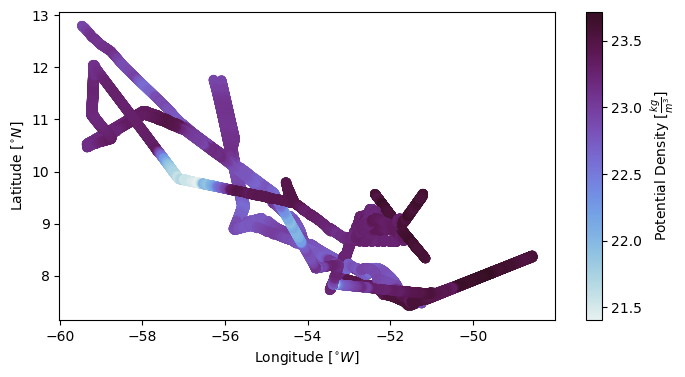

In [12]:
fig = plt.figure(figsize=(8,4))
plt.scatter(sd_nonadcp.sel(saildrone='1060').longitude,
            sd_nonadcp.sel(saildrone='1060').latitude,
            label='1060',c=sd_nonadcp.sel(saildrone='1060').sigma0,
            cmap=cmocean.cm.dense);
plt.scatter(sd_nonadcp.sel(saildrone='1061').longitude,
            sd_nonadcp.sel(saildrone='1061').latitude,
            label='1061',c=sd_nonadcp.sel(saildrone='1060').sigma0,
            cmap=cmocean.cm.dense);
plt.scatter(sd_nonadcp.sel(saildrone='1026').longitude,
            sd_nonadcp.sel(saildrone='1026').latitude,
            label='1026',c=sd_nonadcp.sel(saildrone='1060').sigma0,
            cmap=cmocean.cm.dense);
plt.xlabel(r'Longitude $[^{\circ}W$]')
plt.ylabel(r'Latitude $[^{\circ}N]$')
plt.colorbar(label=r'Potential Density $[\frac{kg}{m^3}]$')


# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/figures/sd_tracks_fig.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)


In [13]:
# total time points in original data 
time_pre = len(adcp.time)

In [14]:
time_pre

13407

### Calculate relative distance and add to dataset 

In [15]:
# this block of code is from Cesar's DensityGradients notebook
# pairwise_distances function is not working because of nans
# will try another function (replaced pairwise_distances with nan_euclidean_distances)

# ***** consider making this into a function **** 

# paralellize this this loop
for i in range(subset.time.size):

    data = subset.isel(time=i)

    theta = data.latitude*np.pi/180

    X=np.vstack([data.longitude/np.cos(theta),data.latitude]).T # CHECK THIS, and note that this is a small angle approximation.
    
    if i == 0:
        dist = 112*nan_euclidean_distances(X)[np.newaxis] # distance matrix in km
    else:
        dist = np.vstack([dist,112*nan_euclidean_distances(X)[np.newaxis]])
        
dd = np.vstack([dist[:,0,1],dist[:,0,2],dist[:,1,2]])

In [16]:
# this block of code is from Cesar's DensityGradients notebook
# pairwise_distances function is not working because of nans
# will try another function (replaced pairwise_distances with nan_euclidean_distances)

# paralellize this this loop
for i in range(sd_nonadcp.time.size):

    data = sd_nonadcp.isel(time=i)

    theta = data.latitude*np.pi/180

    X=np.vstack([data.longitude/np.cos(theta),data.latitude]).T # CHECK THIS, and note that this is a small angle approximation.
    
    if i == 0:
        dist = 112*nan_euclidean_distances(X)[np.newaxis] # distance matrix in km
    else:
        dist = np.vstack([dist,112*nan_euclidean_distances(X)[np.newaxis]])
        
dd_nonadcp = np.vstack([dist[:,0,1],dist[:,0,2],dist[:,1,2]])

In [17]:
dd_nonadcp

array([[408.29340971, 408.25744032, 408.22465085, ..., 108.07528192,
        107.97076485, 107.88671991],
       [ 22.22606409,  22.24057896,  22.24374043, ...,  84.02467497,
         83.81560913,  83.62139495],
       [429.88140238, 429.87056107, 429.84924118, ..., 113.10709091,
        114.11365414, 115.15306554]])

In [18]:
dd

array([[408.30355714, 408.27366207, 408.23502315, ..., 108.12111711,
        108.00826534, 107.91679537],
       [ 22.22468885,  22.23267762,  22.24308584, ...,  84.10076401,
         83.8955941 ,  83.70338823],
       [429.88716122, 429.87449019, 429.85542503, ..., 112.71443812,
        113.69929901, 114.7381926 ]])

In [19]:
len(dist)

13248

In [20]:
len(dd[0])

13047

In [21]:
dist = CalculateDistance(subset.sel(saildrone='1026').longitude,subset.sel(saildrone='1026').latitude)

Text(0, 0.5, 'Relative Distance \n Between Saildrones [km]')

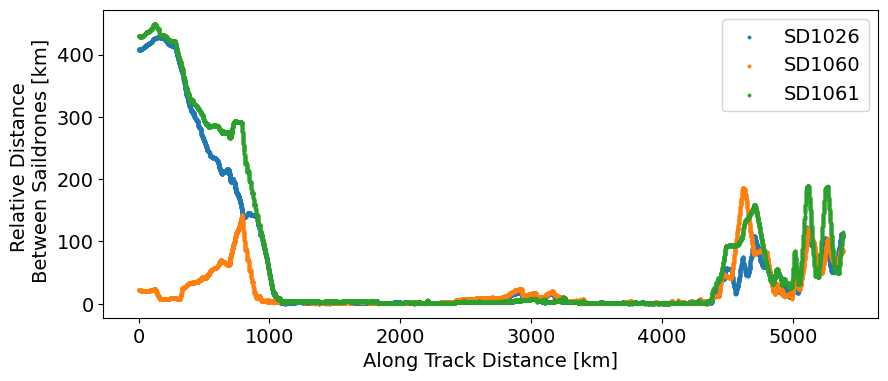

In [22]:
fig = plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
# ax = fig.gca(aspect=1)

plt.scatter(dist,dd[0],label='SD1026',s=3);
plt.scatter(dist,dd[1],label='SD1060',s=3);
plt.scatter(dist,dd[2],label='SD1061',s=3);
plt.legend()
plt.xlabel('Along Track Distance [km]')
plt.ylabel('Relative Distance \n Between Saildrones [km]')

# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/figures/relativedist_fig.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)


In [24]:
# add relative distance to dataset 
subset['relative_dist'] = (['saildrone','time'],dd)
# add relative distance to dataset 
sd_nonadcp['relative_dist'] = (['saildrone','time'],dd_nonadcp)

In [25]:
# define radius parameter 
# parameters
DR = 5             # radius in km

### Figures

In [26]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen
# from cartopy.io.img_tiles import StamenTerrain
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import gsw
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.transforms as mtransforms

#### Manuscript Figure 1. 

In [27]:
# already downloaded data 
smap = xr.open_mfdataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/data/DataMackenzie/SMAP/*.nc4')

In [28]:
smap = smap.sel(time=slice('01-15-2020','03-15-2020'),
         longitude = slice(-62,-48),
         latitude=slice(15,4))

In [29]:
mean_sss = smap.smap_sss.mean('time')

In [30]:
BOX = [-62, -48, 4, 15]
topo = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/data/satellite/etopo1_bed_g2_TropicalAtlantic.nc')
ssh = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/data/satellite/dataset-duacs-nrt-global-merged-allsat-phy-l4_1610638375904.nc')

In [31]:
newcmap = cmocean.tools.crop(cmocean.cm.topo, -6000, 0, 0)

In [32]:
drones = ['1026','1060','1061']

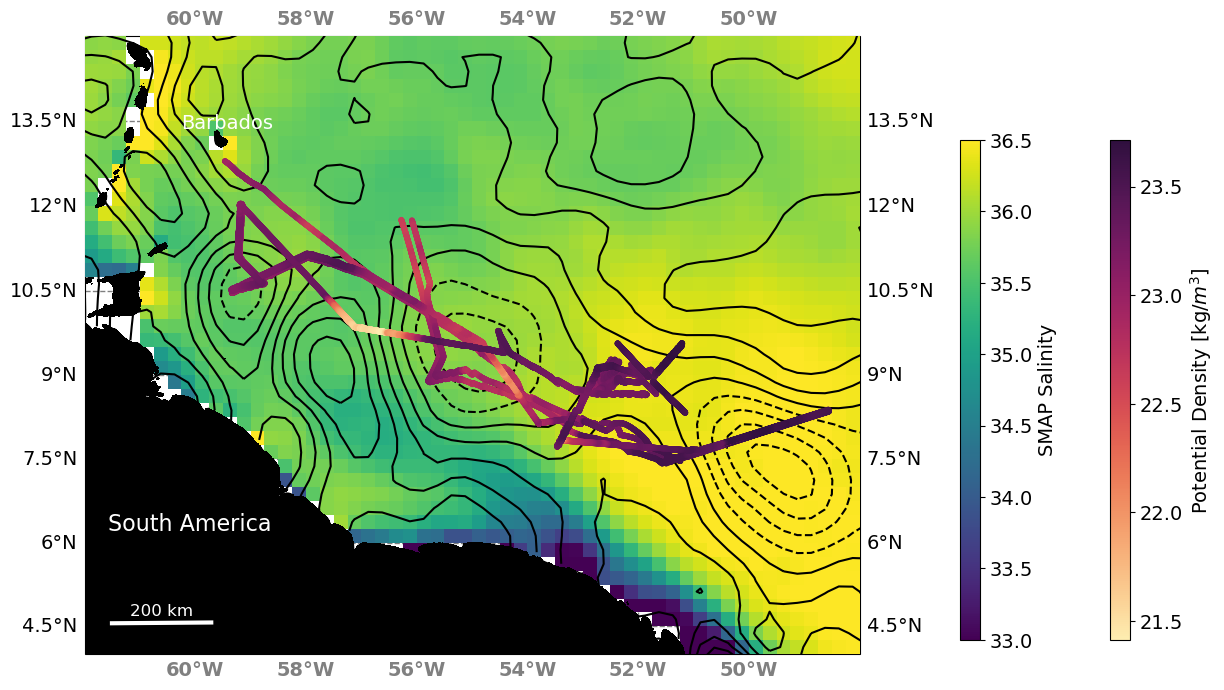

In [33]:
kw = {'cmap':newcmap, 'transform':ccrs.PlateCarree(),
      'add_colorbar':False,
      'levels':np.arange(-6000,500,500),
      'vmax':0}
tiler = Stamen('terrain-background')
mercator = tiler.crs

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=mercator)
ax.set_extent(BOX, crs=ccrs.PlateCarree())
# im=topo.topo.plot.contourf(alpha=0.9,**kw)
topo.topo.plot.contourf(levels=[0,10000],colors='k',transform=ccrs.PlateCarree(),
                        add_colorbar=False,zorder=10,extend='neither')
# ax.add_image(tiler, 6)
ax.coastlines('10m')
ax.xlabel='Longitude'
ax.ylabel='Latitude'
gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  draw_labels=True,linewidth=1,
                  color='gray', alpha=1, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
#plt.colorbar(im,label='topography (m)',orientation="vertical",shrink=0.5,pad=0.07,panchor=(1,0.1))
kw = {'levels':np.arange(-0.15,0.175,.025),'colors':'k'}
sshsubset = ssh.isel(time=28)
plt.contour(sshsubset.longitude,
             sshsubset.latitude,
             sshsubset.sla,
             **kw,transform=ccrs.PlateCarree(),zorder=10)


im = mean_sss.plot(transform=ccrs.PlateCarree(),zorder=9,add_colorbar=False,vmin=33,vmax=36.5)

# for sd,color in zip(drones,colors):
#     nonadcp_all.sel(saildrone=sd).\
#         plot.scatter(x='longitude',y='latitude',label=sd,
#                      color=color,s=10,alpha=0.8,
#                      transform=ccrs.PlateCarree(),zorder=10)

# for sd in drones:
#     nonadcp_all.sel(saildrone=sd).\
#         plot.scatter(x='longitude',y='latitude',c=sd.sigma0,cmap=cmocean.cm.dense,label=sd,
#                      s=10,alpha=0.8,
#                      transform=ccrs.PlateCarree(),zorder=10)
for sd in drones:
    im0 = plt.scatter(sd_nonadcp.sel(saildrone=sd).longitude,
            sd_nonadcp.sel(saildrone=sd).latitude,
            c = sd_nonadcp.sel(saildrone=sd).sigma0,
            cmap = cmocean.cm.matter, label = sd, s=10, transform=ccrs.PlateCarree(),zorder=10)

cbar_ax0 = fig.add_axes([1.15, 0.2, 0.02, 0.5])
fig.colorbar(im0, cax=cbar_ax0,
             label=r'Potential Density [kg/$m^3$]',
            )
    
# scalebar = AnchoredSizeBar(ax.transData,
#                            20, '20 m', 'lower center', 
#                            pad=0.7,
#                            color='white',
#                            frameon=False,
#                            size_vertical=1,
#                            fontproperties=fontprops)

# ax.add_artist(scalebar)


# plt.legend(title='Saildrone',loc=(1.1,0.852))
plt.text(0.03,0.2,'South America',color='w',transform=ax.transAxes,zorder=10,size=16)
plt.text(0.125,0.85,'Barbados',color='w',transform=ax.transAxes,zorder=10,size=14)

scale_bar(ax,length=200,color='w',zorder=12,location=(0.1, 0.05),size=12)

cbar_ax0 = fig.add_axes([1.0, 0.2, 0.02, 0.5])
fig.colorbar(im, cax=cbar_ax0,
             label='SMAP Salinity',extendrect=True 
            )

# plt.savefig('saildrone_traj.png',dpi=400,bbox_inches='tight')
# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/ATOMIC_MesoscaleFront/figures/paper_figs/saildrone_tracks.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)

# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/thesis_figs/sd_tracks.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)
            

#### Manuscript Figure 2. 

In [34]:
# keep only that whose max(relative_distance)<=DR
subset_reduced = subset.where(np.max(subset.relative_dist,axis=0)<=DR,drop=True)

In [35]:
sd_nonadcp_reduced = sd_nonadcp.where(np.max(sd_nonadcp.relative_dist,axis=0)<=DR,drop=True)

In [36]:
subset1 = subset.sel(time=slice('2020-02-14T04:45','2020-02-14T08:50'))

In [37]:
# Calculate the mean lon/lat and central point of the resample
mean_lon = np.mean(subset1.longitude)
mean_lat = np.mean(subset1.latitude)
central_point = (mean_lon,mean_lat)

In [38]:
lonc = subset1.longitude.mean()
latc = subset1.latitude.mean()
theta = subset1.latitude*np.pi/180
dlon = subset1.longitude-lonc
dlat = subset1.latitude-latc
dx = 111*dlon*np.cos(theta) #[m]  
dy = 111*dlat #

/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_15782/2607213708.py:13: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  fig.gca(aspect=1)


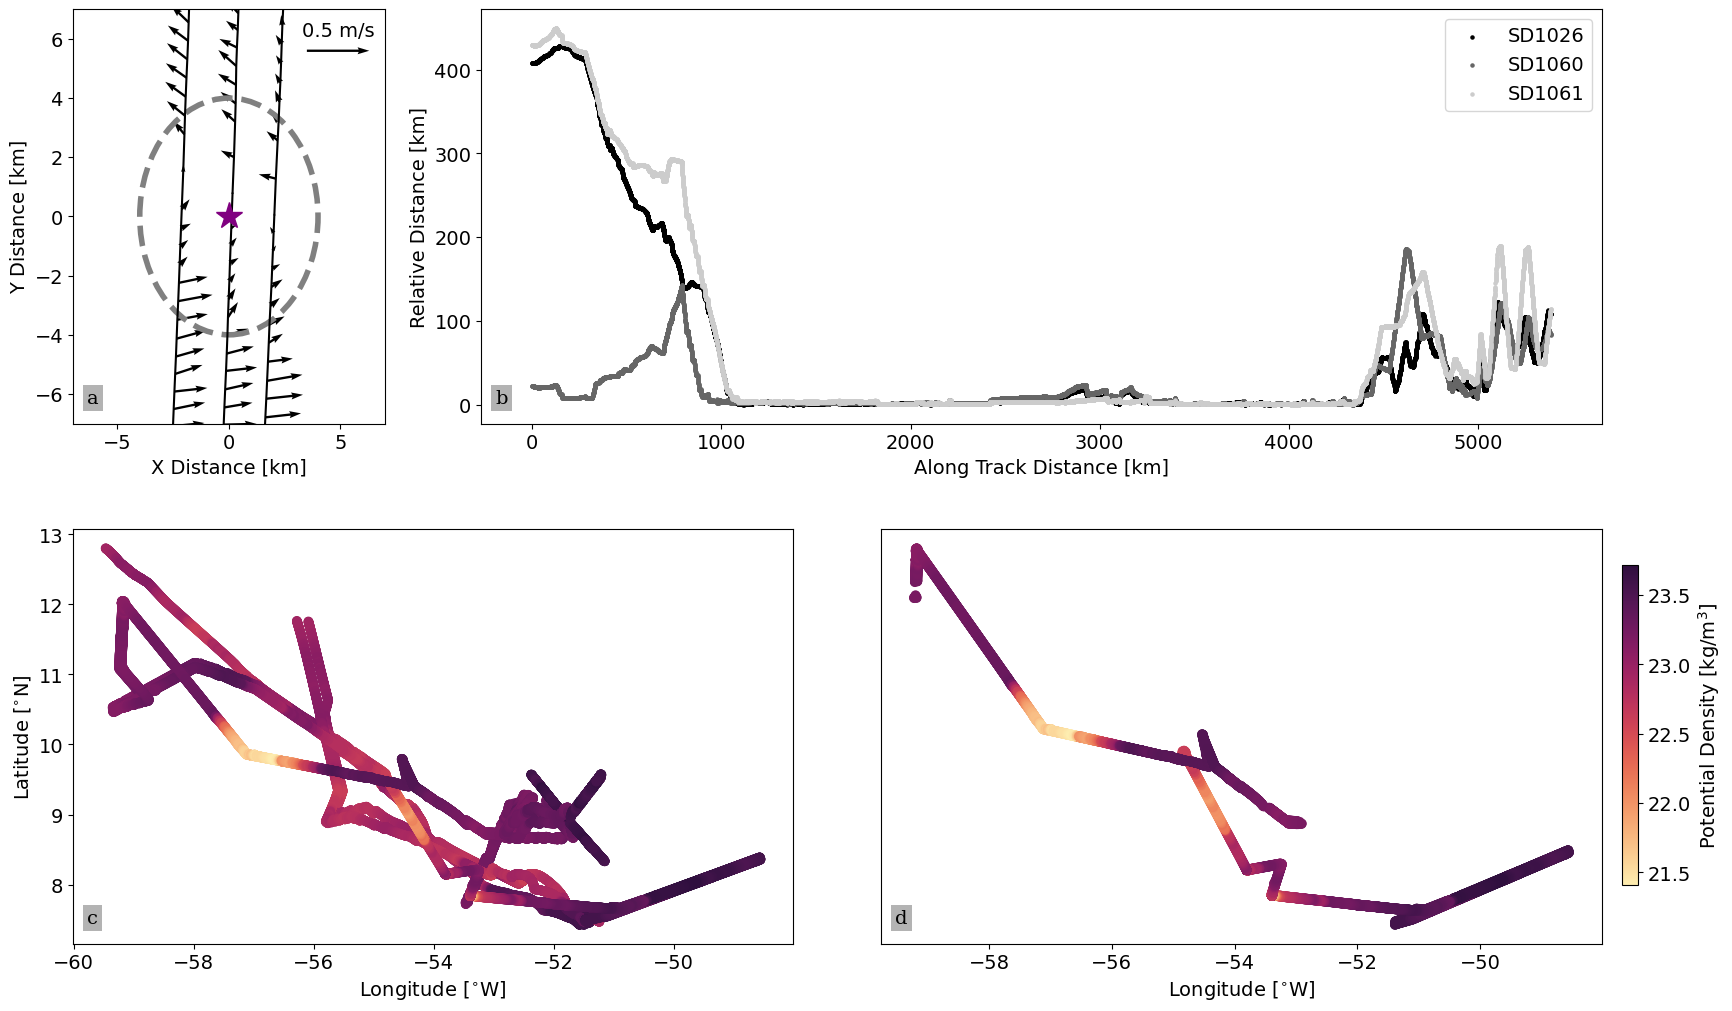

In [41]:
# ------------- CREATE SUBPLOT MOSIAC LAYOUT --------------------------------
fig, axs = plt.subplot_mosaic([['a','b','b','b'],['c','c','d','d']],constrained_layout=True,
                              figsize=(16,10),
                                  gridspec_kw={
                                    "wspace": 0,
                                      "hspace":0.1,
                                    "right": 10})



# ------------------- SUBPLOT A ------------------------------

fig.gca(aspect=1)
axs['a'].plot(dx.sel(saildrone='1026'),
           dy.sel(saildrone='1026'),color='k')

axs['a'].quiver(dx.sel(saildrone='1026')[::1],
           dy.sel(saildrone='1026')[::1],
           subset1.sel(saildrone='1026').isel(depth=0).u[::1],
           subset1.sel(saildrone='1026').isel(depth=0).v[::1],scale=2.5)

axs['a'].plot(dx.sel(saildrone='1060'),
           dy.sel(saildrone='1060'),color='k')

axs['a'].quiver(dx.sel(saildrone='1060')[::1],
           dy.sel(saildrone='1060')[::1],
           subset1.sel(saildrone='1060').isel(depth=0).u[::1],
           subset1.sel(saildrone='1060').isel(depth=0).v[::1],scale=2.5)

axs['a'].plot(dx.sel(saildrone='1061'),
           dy.sel(saildrone='1061'),color='k')

q=axs['a'].quiver(dx.sel(saildrone='1061')[::1],
           dy.sel(saildrone='1061')[::1],
           subset1.sel(saildrone='1061').isel(depth=0).u[::1],
           subset1.sel(saildrone='1061').isel(depth=0).v[::1],scale=2.5)

axs['a'].plot(0,0,"*",color='purple',markersize=20)

circle = plt.Circle((0,0), 4, color='0.5',linestyle='dashed', fill=False,linewidth=4)

axs['a'].add_patch(circle)
axs['a'].quiverkey(q, X=0.85, Y=0.9, U=0.5,
             label='0.5 m/s')

axs['a'].set_xlabel('X Distance [km]')
axs['a'].set_ylabel('Y Distance [km]')

axs['a'].set_xlim(-7,7)
axs['a'].set_ylim(-7,7)



# -------------- SUBPLOT B ------------------
axs['b'].scatter(dist,dd[0],label='SD1026',color='0',s=5);
axs['b'].scatter(dist,dd[1],label='SD1060',color='0.4',s=5);
axs['b'].scatter(dist,dd[2],label='SD1061',color='0.8',s=5);
axs['b'].legend()
axs['b'].set_xlabel('Along Track Distance [km]')
axs['b'].set_ylabel('Relative Distance [km]')


# -------------- SUBPLOT C ------------------

im = axs['c'].scatter(sd_nonadcp.sel(saildrone='1060').longitude,sd_nonadcp.sel(saildrone='1060').latitude,label='1060',c=sd_nonadcp.sel(saildrone='1060').sigma0,cmap=cmocean.cm.matter);
axs['c'].scatter(sd_nonadcp.sel(saildrone='1061').longitude,sd_nonadcp.sel(saildrone='1061').latitude,label='1061',c=sd_nonadcp.sel(saildrone='1060').sigma0,cmap=cmocean.cm.matter);
axs['c'].scatter(sd_nonadcp.sel(saildrone='1026').longitude,sd_nonadcp.sel(saildrone='1026').latitude,label='1026',c=sd_nonadcp.sel(saildrone='1060').sigma0,cmap=cmocean.cm.matter);
axs['c'].set_xlabel(r'Longitude [$^{\circ}$W]')
axs['c'].set_ylabel(r'Latitude [$^{\circ}$N]')
# plt.colorbar(label=r'Potential Density $[\frac{kg}{m^3}]$',im=im)

# -------------- SUBPLOT D ------------------

im = axs['d'].scatter(sd_nonadcp_reduced.sel(saildrone='1060').longitude,sd_nonadcp_reduced.sel(saildrone='1060').latitude,label='1060',c=sd_nonadcp_reduced.sel(saildrone='1060').sigma0,cmap=cmocean.cm.matter);
axs['d'].scatter(sd_nonadcp_reduced.sel(saildrone='1061').longitude,sd_nonadcp_reduced.sel(saildrone='1061').latitude,label='1061',c=sd_nonadcp_reduced.sel(saildrone='1060').sigma0,cmap=cmocean.cm.matter);
axs['d'].scatter(sd_nonadcp_reduced.sel(saildrone='1026').longitude,sd_nonadcp_reduced.sel(saildrone='1026').latitude,label='1026',c=sd_nonadcp_reduced.sel(saildrone='1060').sigma0,cmap=cmocean.cm.matter);
axs['d'].set_xlabel(r'Longitude [$^{\circ}$W]')
# axs['d'].set_ylabel(r'Latitude $[^{\circ}N]$')
axs['d'].set_yticks([])

# add colorbar 
cbar_ax0 = fig.add_axes([1.01, 0.12, 0.01, 0.32])
fig.colorbar(im, cax=cbar_ax0,
             label=r'Potential Density [kg/m$^3$]',
            )

for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 0.1, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/figures/methods_mosiac.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)
            

### Back to Analysis

In [44]:
# keep only that whose max(relative_distance)<=DR
subset = subset.where(np.max(subset.relative_dist,axis=0)<=DR,drop=True)

In [45]:
time_post = len(subset.time)

In [46]:
time_post

5875

In [47]:
(time_post/time_pre) * 100 

43.82039233236369

 approximatey %45 of the data is removed after dropping relative distances greater than 5 km

In [48]:
sd_nonadcp = sd_nonadcp.where(np.max(sd_nonadcp.relative_dist,axis=0)<=DR,drop=True)

In [50]:
dist_sd1060 = CalculateDistance(subset.longitude.sel(saildrone='1060'),subset.latitude.sel(saildrone='1060'))
dist_sd1061 = CalculateDistance(subset.longitude.sel(saildrone='1061'),subset.latitude.sel(saildrone='1061'))
dist_sd1026 = CalculateDistance(subset.longitude.sel(saildrone='1026'),subset.latitude.sel(saildrone='1026'))

In [51]:
np.mean([dist_sd1060[-1],dist_sd1061[-1],dist_sd1026[-1]])

2966.606038805032

In [52]:
sd_nonadcp['relative_dist'] = sd_nonadcp.relative_dist.assign_attrs(units='km',long_name='Relative Distance Between Saildrones',
                                      description='Calculated via euclidean distances')

In [53]:
sd_nonadcp

<xarray.Dataset>
Dimensions:            (time: 5992, saildrone: 3)
Coordinates:
    latitude           (time, saildrone) float64 ...
    longitude          (time, saildrone) float64 ...
  * saildrone          (saildrone) float32 1.026e+03 1.06e+03 1.061e+03
  * time               (time) datetime64[ns] 2020-01-26T20:45:00 ... 2020-02-...
Data variables: (12/13)
    UWND_MEAN          (time, saildrone) float64 -6.42 -6.612 ... -9.68 -8.692
    UWND_STDDEV        (time, saildrone) float64 0.512 0.522 ... 0.914 0.892
    VWND_MEAN          (time, saildrone) float64 -3.304 -2.92 ... -1.882 -2.562
    VWND_STDDEV        (time, saildrone) float64 0.476 0.464 ... 0.666 0.712
    WWND_MEAN          (time, saildrone) float64 -0.072 -0.024 ... -0.008 -0.11
    WWND_STDDEV        (time, saildrone) float64 0.348 0.318 ... 0.506 0.47
    ...                 ...
    TEMP_SBE37_STDDEV  (time, saildrone) float64 0.00122 0.00092 ... 0.0005
    SAL_SBE37_MEAN     (time, saildrone) float64 36.42 36.43 ... 35.83 35.93
    SAL_SBE37_STDDEV   (time, saildrone) float64 0.0004 0.00116 ... 0.0004
    sigma0             (time, saildrone) float64 23.56 23.57 ... 23.2 23.27
    b                  (time, saildrone) float64 0.003661 0.003697 ... 0.0008925
    relative_dist      (saildrone, time) float64 2.219 1.814 ... 4.467 4.888
Attributes: (12/38)
    title:                     ATOMIC-EUREC4A 2020 Surface Data - 1 min
    summary:                   This data set was collected by three saildrone...
    ncei_template_version:     NCEI_NetCDF_Trajectory_Template_v2.0
    Conventions:               CF-1.6, ACDD-1.3
    netcdf_version:            4.6.3
    featureType:               trajectory
    ...                        ...
    geospatial_lat_min:        7.4658584
    geospatial_lat_max:        12.051028
    geospatial_lat_units:      degrees_north
    geospatial_lon_min:        -59.3422848
    geospatial_lon_max:        -48.5522528
    geospatial_lon_units:      degrees_east

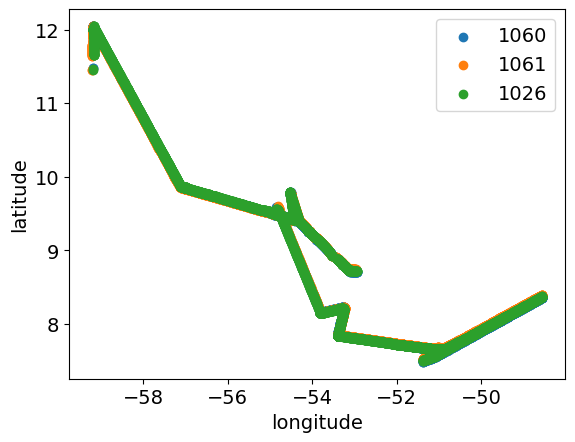

In [54]:
# new plot showing the removal of data that was too far apart 
plt.scatter(subset.sel(saildrone='1060').longitude,
            subset.sel(saildrone='1060').latitude,
            label='1060');
plt.scatter(subset.sel(saildrone='1061').longitude,
            subset.sel(saildrone='1061').latitude,
            label='1061');
plt.scatter(subset.sel(saildrone='1026').longitude,
            subset.sel(saildrone='1026').latitude,
            label='1026');
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend()
# plt.savefig('/home/mlb15109/Research/ATOMIC/figures/gradientcalc_sensitivity/tracksRD3.jpeg',dpi=200,bbox_inches='tight')

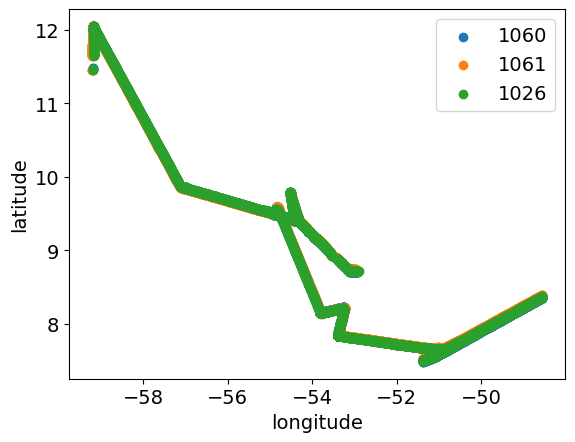

In [55]:
# new plot showing the removal of data that was too far apart 
plt.scatter(sd_nonadcp.sel(saildrone='1060').longitude,
         sd_nonadcp.sel(saildrone='1060').latitude,label='1060');
plt.scatter(sd_nonadcp.sel(saildrone='1061').longitude,
         sd_nonadcp.sel(saildrone='1061').latitude,label='1061');
plt.scatter(sd_nonadcp.sel(saildrone='1026').longitude,
         sd_nonadcp.sel(saildrone='1026').latitude,label='1026');
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend()

#### calculate average distance in each approximation 

In [57]:
# subset,timec = GetDataIntervals(dataset,i=i,interval=interval)
subset_list = []
for i in range(len(sd_nonadcp.time)):
    subset_list.append(GetDataIntervals(sd_nonadcp,i=i,interval=15)[0])

In [58]:
for i in range(len(subset_list)):
    distance = CalculateDistance(subset_list[i].sel(saildrone='1060').longitude,
                      subset_list[i].sel(saildrone='1060').latitude)
    subset_list[i]['distance'] = ('time',distance)

In [66]:
max_dist = []
for i in range(len(subset_list)):
    max_dist.append(subset_list[i].distance.max())

In [67]:
max_dist = xr.DataArray(max_dist)

In [90]:
max_dist.mean(), max_dist.max(), max_dist.min()

(<xarray.DataArray ()>
 array(2.42948986),
 <xarray.DataArray ()>
 array(5.44273352),
 <xarray.DataArray ()>
 array(0.))

should probably throw out the fits that have zero distance - maybe they get thrown out anyway ?

I think they will get thrown out if the number of points per fit is small 

#### Calculate non-adcp gradients (buoyancy, density, temperature, salinity)

In [48]:
# set parameters for interval and k (i.e. time interval for data and how many points you need to do the least squares fit - default is 15min and 2 points)
# interval needs to be an integer 
interval = 15
k = 3

In [24]:
# calculate density coefficients 
coefs_density = Coefs_Dataset(subset=sd_nonadcp,
                     variable='sigma0',
                     var1 = 'rho_mean',
                     var2 = 'rhox',
                     var3 = 'rhoy',
                     interval = interval,
                     k=k,
                     j=False)

In [25]:
coefs_density

<xarray.Dataset>
Dimensions:    (time: 5992)
Coordinates:
    longitude  (time) float64 -51.38 -51.38 -51.38 ... -52.95 -52.95 -52.92
    latitude   (time) float64 7.502 7.503 7.503 7.504 ... 8.719 8.719 8.716
  * time       (time) datetime64[ns] 2020-01-26T20:45:00 ... 2020-02-23T04:35:00
Data variables:
    rho_mean   (time) float64 23.57 23.57 23.57 23.57 ... 23.22 23.22 23.23
    rhox       (time) float64 -1.498e-06 -1.011e-06 ... -4.426e-06 -1.559e-05
    rhoy       (time) float64 6.884e-07 7.53e-07 ... 1.923e-05 6.029e-06

In [31]:
coefs_density.to_netcdf('data/coefs_density.nc')

In [26]:
# get coefs for b 
# Already ran this so just open saved dataset


coefs_b = Coefs_Dataset(subset=sd_nonadcp,
                     variable='b',
                     var1 = 'b_mean',
                     var2 = 'bx',
                     var3 = 'by',
                     interval = interval,
                     k=k,
                     j=False)

In [27]:
coefs_b.to_netcdf('data/coefs_b.nc')

In [27]:
coefs_temp = Coefs_Dataset(subset=sd_nonadcp,
                     variable='TEMP_SBE37_MEAN',
                     var1 = 't_mean',
                     var2 = 'tx',
                     var3 = 'ty',
                     interval = interval,
                     k=k,
                     j=False)

In [28]:
coefs_temp_error = Coefs_Dataset_Error(subset=sd_nonadcp,
                     variable='TEMP_SBE37_STDDEV',
                     var1 = 't_mean_error',
                     var2 = 'tx_error',
                     var3 = 'ty_error',
                     interval = interval,
                     k=k,
                     j=False)

In [32]:
coefs_temp.to_netcdf('data/coefs_temp.nc')

In [33]:
coefs_temp_error.to_netcdf('data/coefs_temp_error.nc')

In [29]:
coefs_sal = Coefs_Dataset(subset=sd_nonadcp,
                     variable='SAL_SBE37_MEAN',
                     var1 = 'sal_mean',
                     var2 = 'salx',
                     var3 = 'saly',
                     interval = interval,
                     k=k,
                     j=False)

In [30]:
coefs_sal_error = Coefs_Dataset_Error(subset=sd_nonadcp,
                     variable='SAL_SBE37_STDDEV',
                     var1 = 'sal_mean_error',
                     var2 = 'salx_error',
                     var3 = 'saly_error',
                     interval = interval,
                     k=k,
                     j=False)

In [34]:
coefs_sal.to_netcdf('data/coefs_sal.nc')

In [35]:
coefs_sal_error.to_netcdf('data/coefs_sal_error.nc')

In [36]:
coefs_nonadcp = xr.merge([coefs_sal,coefs_density,coefs_temp,coefs_b])
coefs_nonadcp.to_netcdf('data/coefs_nonadcp.nc')

In [37]:
coefs_nonadcp

<xarray.Dataset>
Dimensions:    (time: 5992)
Coordinates:
    longitude  (time) float64 -51.38 -51.38 -51.38 ... -52.95 -52.95 -52.92
    latitude   (time) float64 7.502 7.503 7.503 7.504 ... 8.719 8.719 8.716
  * time       (time) datetime64[ns] 2020-01-26T20:45:00 ... 2020-02-23T04:35:00
Data variables:
    sal_mean   (time) float64 36.43 36.43 36.43 36.43 ... 35.86 35.86 35.86
    salx       (time) float64 -5.144e-06 -4.938e-06 ... -9.993e-06 -2.226e-05
    saly       (time) float64 1.757e-07 2.982e-07 ... 2.145e-05 6.982e-06
    rho_mean   (time) float64 23.57 23.57 23.57 23.57 ... 23.22 23.22 23.23
    rhox       (time) float64 -1.498e-06 -1.011e-06 ... -4.426e-06 -1.559e-05
    rhoy       (time) float64 6.884e-07 7.53e-07 ... 1.923e-05 6.029e-06
    t_mean     (time) float64 27.26 27.26 27.26 27.26 ... 27.02 27.02 27.02
    tx         (time) float64 -7.081e-06 -8.118e-06 ... -9.163e-06 -2.51e-06
    ty         (time) float64 -1.728e-06 -1.649e-06 ... -1.071e-05 -2.759e-06
    b_mean     (time) float64 0.003694 0.003696 0.003697 ... 0.0004193 0.0004338
    bx         (time) float64 -1.435e-08 -9.684e-09 ... -4.24e-08 -1.494e-07
    by         (time) float64 6.595e-09 7.214e-09 ... 1.843e-07 5.776e-08

#### Calculate the gradients from adcp data (u and v)

In [55]:
subset

In [25]:
# #Get the coefficients for u and v gradients 
coefs_u = []
for j in range(len(subset.depth)):
    subset1 = subset.isel(depth=j)
    coefs_u.append(Coefs_Dataset(subset=subset1,
                     variable='u',
                     var1 = 'u_mean',
                     var2 = 'ux',
                     var3 = 'uy',
                     interval = interval,
                     k = k,
                     j=True))
coefs_u = xr.merge(coefs_u)

In [28]:
coefs_u

<xarray.Dataset>
Dimensions:    (time: 5982, depth: 50)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-26T20:45:00 ... 2020-02-23T04:10:00
  * depth      (depth) float64 4.2 6.2 8.2 10.2 12.2 ... 96.2 98.2 100.2 102.2
    longitude  (time) float64 -51.38 -51.38 -51.38 ... -52.95 -52.95 -52.95
    latitude   (time) float64 7.502 7.502 7.503 7.503 ... 8.719 8.719 8.719
Data variables:
    u_mean     (depth, time) float64 -0.06367 -0.0596 -0.05717 ... nan nan nan
    ux         (depth, time) float64 -9.871e-07 1.211e-05 1.53e-05 ... nan nan
    uy         (depth, time) float64 6.375e-06 4.916e-06 4.451e-06 ... nan nan

In [29]:
# #Get the coefficients for u and v gradients 
coefs_v = []
for j in range(len(subset.depth)):
    subset1 = subset.isel(depth=j)
    coefs_v.append(Coefs_Dataset(subset=subset1,
                     variable='v',
                     var1 = 'v_mean',
                     var2 = 'vx',
                     var3 = 'vy',
                     interval = interval,
                     k = k,
                     j=True))
coefs_v = xr.merge(coefs_v)

In [30]:
coefs_v

<xarray.Dataset>
Dimensions:    (time: 5982, depth: 50)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-26T20:45:00 ... 2020-02-23T04:10:00
  * depth      (depth) float64 4.2 6.2 8.2 10.2 12.2 ... 96.2 98.2 100.2 102.2
    longitude  (time) float64 -51.38 -51.38 -51.38 ... -52.95 -52.95 -52.95
    latitude   (time) float64 7.502 7.502 7.503 7.503 ... 8.719 8.719 8.719
Data variables:
    v_mean     (depth, time) float64 -0.1382 -0.1397 -0.1397 ... nan nan nan
    vx         (depth, time) float64 -9.824e-06 -8.066e-06 -5.77e-06 ... nan nan
    vy         (depth, time) float64 4.422e-06 3.172e-06 1.268e-06 ... nan nan

In [31]:
#Get the coefficients for u and v gradients 
coefs_e = []
for j in range(len(subset.depth)):
    subset1 = subset.isel(depth=j)
    coefs_e.append(Coefs_Dataset_Error(subset=subset1,
                     variable='e',
                     var1 = 'e_mean',
                     var2 = 'ex',
                     var3 = 'ey',
                     interval = interval,
                     k = k,
                     j=True))
coefs_e = xr.merge(coefs_e)

/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/utilities/Gradient_LeastSquares.py:34: RuntimeWarning: invalid value encountered in sqrt
  error = np.sqrt(variance)
/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/utilities/Gradient_LeastSquares.py:34: RuntimeWarning: invalid value encountered in sqrt
  error = np.sqrt(variance)
/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/utilities/Gradient_LeastSquares.py:34: RuntimeWarning: invalid value encountered in sqrt
  error = np.sqrt(variance)
/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/utilities/Gradient_LeastSquares.py:34: RuntimeWarning: invalid value encountered in sqrt
  error = np.sqrt(variance)
/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/utilities/Gradient_LeastSquares.py:34: RuntimeWarning: invalid value encountered in sqrt
  error 

In [32]:
coefs_e

<xarray.Dataset>
Dimensions:    (time: 5982, depth: 50)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-26T20:45:00 ... 2020-02-23T04:10:00
  * depth      (depth) float64 4.2 6.2 8.2 10.2 12.2 ... 96.2 98.2 100.2 102.2
    longitude  (time) float64 -51.38 -51.38 -51.38 ... -52.95 -52.95 -52.95
    latitude   (time) float64 7.502 7.502 7.503 7.503 ... 8.719 8.719 8.719
Data variables:
    e_mean     (depth, time) float64 0.002 0.001067 0.001056 ... nan nan nan
    ex         (depth, time) float64 4.893e-07 1.884e-06 2.17e-06 ... nan nan
    ey         (depth, time) float64 1.907e-06 1.079e-06 1.389e-06 ... nan nan

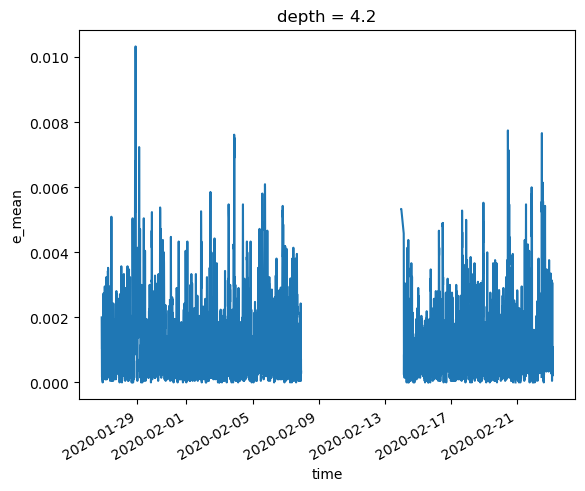

In [36]:
coefs.isel(depth=0).e_mean.plot()

In [34]:
coefs = xr.merge([coefs_v,coefs_u,coefs_e])

In [35]:
coefs.to_netcdf('data/coefs.nc')

In [6]:
coefs = xr.open_dataset('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/data/coefs.nc')

### Plot the gradients 

In [7]:
coefs_subset = coefs.isel(depth=slice(0,10))

In [46]:
coefs_subset.ux.mean()

<xarray.DataArray 'ux' ()>
array(7.17224406e-07)

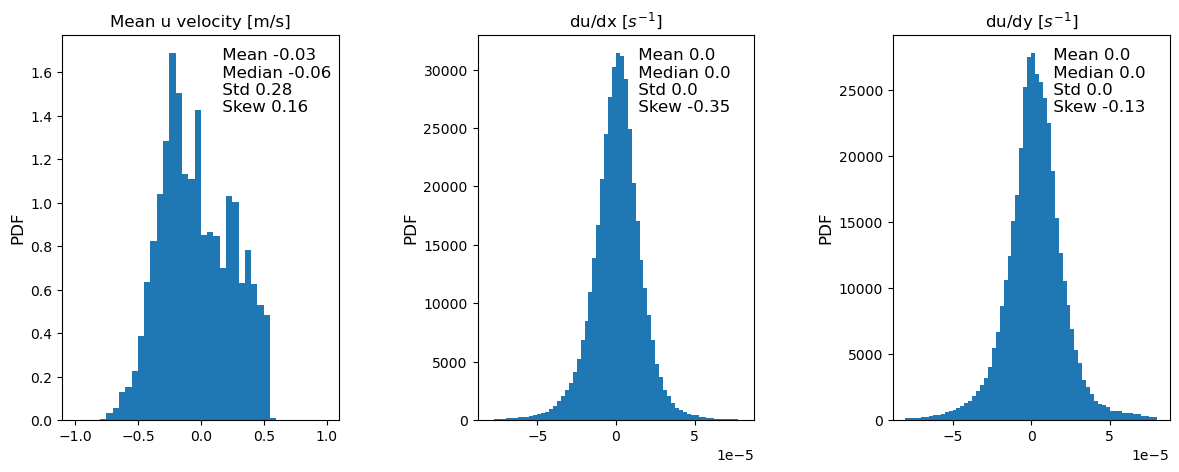

In [44]:
# dbins, bmin, bmax = 0.00025, -0.005, 0.005
coefs_subset = coefs.isel(depth=slice(0,24))
# coefs_subset1 = coefs.isel(depth=slice(0,10))
fig = plt.figure(figsize=(25,5))
ax0 = fig.add_subplot(151)
ax1 = fig.add_subplot(152)
ax2 = fig.add_subplot(153)

dbins, bmin, bmax = 0.05, -1, 1
img0 = ax0.hist(coefs_subset.u_mean.values.flatten(),density=True,bins=np.arange(bmin,bmax+dbins,dbins))
# ax0.hist(coefs_subset1.u_mean.values.flatten(),density=True,bins=np.arange(bmin,bmax+dbins,dbins),
#          histtype='step',color='r')


# # plot normal distribution on top 
# x = np.linspace(bmin, bmax, 100)
# mu = np.nanmean(coefs.vort.values.flatten())
# std = np.nanstd(coefs.vort.values.flatten())
# p = norm.pdf(x, mu, std) 
# ax0.plot(x, p, 'k', linewidth=2, linestyle='dashed',alpha=0.5,label='Gaussian')
# ax0.legend()
dbins, bmin, bmax = 0.0000025, -0.00008, 0.00008
img1 = ax1.hist(coefs_subset.ux.values.flatten(),density=True,bins=np.arange(bmin,bmax+dbins,dbins))

# plot normal distribution on top 
# x = np.linspace(bmin, bmax, 100)
# mu = np.nanmean(coefs.div.values.flatten())
# std = np.nanstd(coefs.div.values.flatten())
# p = norm.pdf(x, mu, std) 
# ax1.plot(x, p, 'k', linewidth=2, linestyle='dashed',alpha=0.5,label='Gaussian')
# ax1.legend()

dbins, bmin, bmax = 0.0000025, -0.00008, 0.00008
img2 = ax2.hist(coefs_subset.uy.values.flatten(),density=True,bins=np.arange(bmin,bmax+dbins,dbins))

# plot normal distribution on top 
# x = np.linspace(0, bmax, 100)
# mu = np.nanmean(coefs.strain.values.flatten())
# std = np.nanstd(coefs.strain.values.flatten())
# p = norm.pdf(x, mu, std) 
# ax2.plot(x, p, 'k', linewidth=2, linestyle='dashed',alpha=0.5,label='Gaussian')
# ax2.legend()

ax0.set_title('Mean u velocity [m/s]',fontsize=12)
ax0.set_ylabel('PDF',fontsize=12)
ax1.set_title(r'du/dx $[s^{-1}]$',fontsize=12)
ax1.set_ylabel('PDF',fontsize=12)
ax2.set_title(r'du/dy $[s^{-1}]$',fontsize=12)
ax2.set_ylabel('PDF',fontsize=12)

plt.subplots_adjust(wspace=0.5)
        
for ax,var in zip([ax0, 
                   ax1, 
                   ax2],
                  [coefs_subset.u_mean.values.flatten(),
                   coefs_subset.ux.values.flatten(),
                   coefs_subset.uy.values.flatten()]):
        ax.text(.56,0.88,
                (f' Mean {get_stats(var)[0]} \n Median {get_stats(var)[1]} \n Std {get_stats(var)[2]} \n Skew {get_stats(var)[3]}'.format()),
        ha='left',va='center',transform=ax.transAxes,fontsize=12)

# # # plt.savefig('/home/mlb15109/Research/ATOMIC/figures/gradientcalc_sensitivity/RD5_Int10_k2.jpeg',dpi=200,bbox_inches='tight')
# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/ATOMIC_MesoscaleFront/figures/paper_figs/Error_PDFS.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)

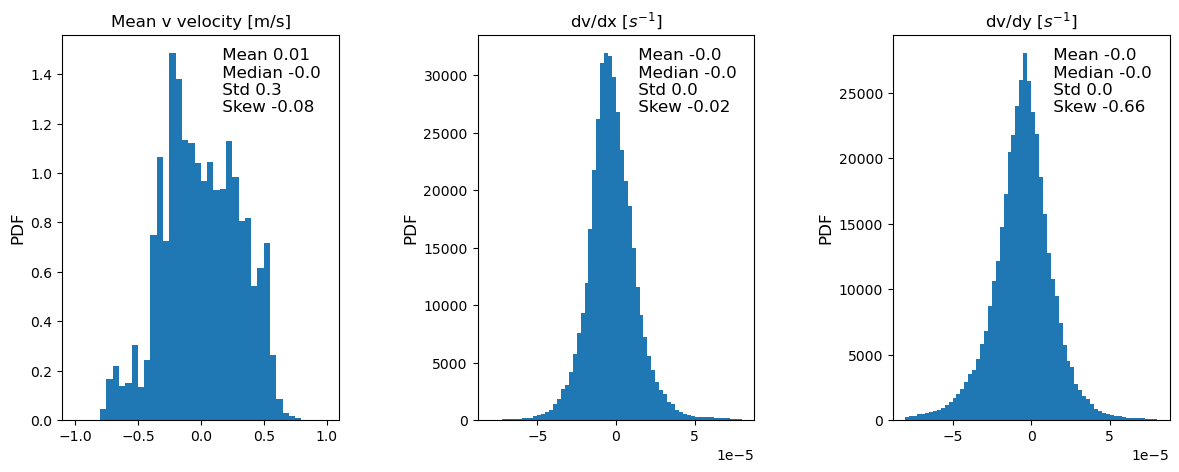

In [45]:
# dbins, bmin, bmax = 0.00025, -0.005, 0.005
coefs_subset = coefs.isel(depth=slice(0,24))
# coefs_subset1 = coefs.isel(depth=slice(0,10))
fig = plt.figure(figsize=(25,5))
ax0 = fig.add_subplot(151)
ax1 = fig.add_subplot(152)
ax2 = fig.add_subplot(153)

dbins, bmin, bmax = 0.05, -1, 1
img0 = ax0.hist(coefs_subset.v_mean.values.flatten(),density=True,bins=np.arange(bmin,bmax+dbins,dbins))
# ax0.hist(coefs_subset1.u_mean.values.flatten(),density=True,bins=np.arange(bmin,bmax+dbins,dbins),
#          histtype='step',color='r')


# # plot normal distribution on top 
# x = np.linspace(bmin, bmax, 100)
# mu = np.nanmean(coefs.vort.values.flatten())
# std = np.nanstd(coefs.vort.values.flatten())
# p = norm.pdf(x, mu, std) 
# ax0.plot(x, p, 'k', linewidth=2, linestyle='dashed',alpha=0.5,label='Gaussian')
# ax0.legend()
dbins, bmin, bmax = 0.0000025, -0.00008, 0.00008
img1 = ax1.hist(coefs_subset.vx.values.flatten(),density=True,bins=np.arange(bmin,bmax+dbins,dbins))

# plot normal distribution on top 
# x = np.linspace(bmin, bmax, 100)
# mu = np.nanmean(coefs.div.values.flatten())
# std = np.nanstd(coefs.div.values.flatten())
# p = norm.pdf(x, mu, std) 
# ax1.plot(x, p, 'k', linewidth=2, linestyle='dashed',alpha=0.5,label='Gaussian')
# ax1.legend()

dbins, bmin, bmax = 0.0000025, -0.00008, 0.00008
img2 = ax2.hist(coefs_subset.vy.values.flatten(),density=True,bins=np.arange(bmin,bmax+dbins,dbins))

# plot normal distribution on top 
# x = np.linspace(0, bmax, 100)
# mu = np.nanmean(coefs.strain.values.flatten())
# std = np.nanstd(coefs.strain.values.flatten())
# p = norm.pdf(x, mu, std) 
# ax2.plot(x, p, 'k', linewidth=2, linestyle='dashed',alpha=0.5,label='Gaussian')
# ax2.legend()

ax0.set_title('Mean v velocity [m/s]',fontsize=12)
ax0.set_ylabel('PDF',fontsize=12)
ax1.set_title(r'dv/dx $[s^{-1}]$',fontsize=12)
ax1.set_ylabel('PDF',fontsize=12)
ax2.set_title(r'dv/dy $[s^{-1}]$',fontsize=12)
ax2.set_ylabel('PDF',fontsize=12)

plt.subplots_adjust(wspace=0.5)
        
for ax,var in zip([ax0, 
                   ax1, 
                   ax2],
                  [coefs_subset.v_mean.values.flatten(),
                   coefs_subset.vx.values.flatten(),
                   coefs_subset.vy.values.flatten()]):
        ax.text(.56,0.88,
                (f' Mean {get_stats(var)[0]} \n Median {get_stats(var)[1]} \n Std {get_stats(var)[2]} \n Skew {get_stats(var)[3]}'.format()),
        ha='left',va='center',transform=ax.transAxes,fontsize=12)

# # # plt.savefig('/home/mlb15109/Research/ATOMIC/figures/gradientcalc_sensitivity/RD5_Int10_k2.jpeg',dpi=200,bbox_inches='tight')
# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/ATOMIC_MesoscaleFront/figures/paper_figs/Error_PDFS.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)

In [29]:
def get_stats(X,round=2):
    return np.round(np.nanmean(X),round), np.round(np.nanmedian(X),round), np.round(np.nanstd(X),round), np.round(stats.skew(X,nan_policy='omit'),round)

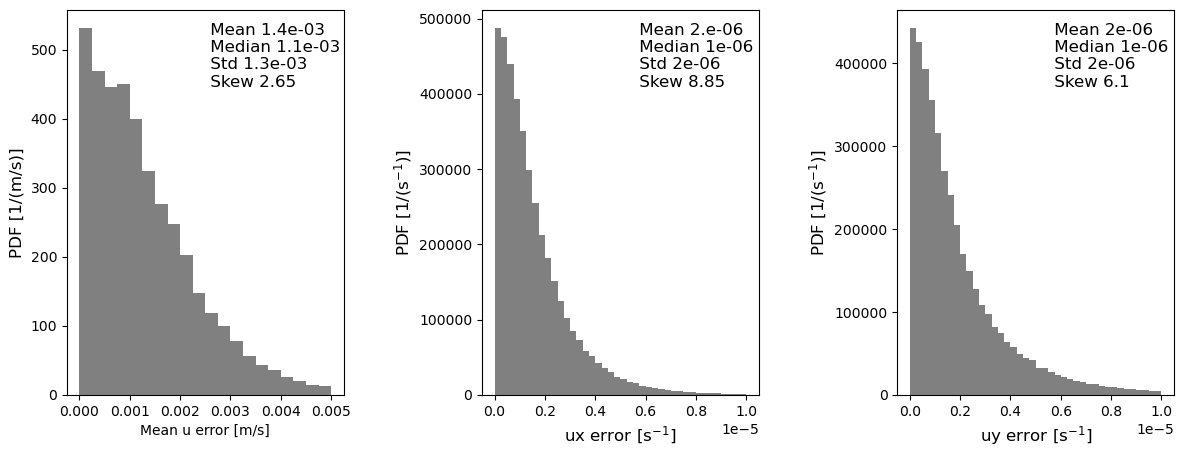

In [41]:
# dbins, bmin, bmax = 0.00025, -0.005, 0.005
coefs_subset = coefs.isel(depth=slice(0,24))
fig = plt.figure(figsize=(25,5))
ax0 = fig.add_subplot(151)
ax1 = fig.add_subplot(152)
ax2 = fig.add_subplot(153)

dbins, bmin, bmax = 0.00025, -0.005, 0.005
img0 = ax0.hist(coefs_subset.e_mean.values.flatten(),density=True,bins=np.arange(0,bmax+dbins,dbins),color='grey')

dbins, bmin, bmax = 0.00000025, -0.00001, 0.00001
img1 = ax1.hist(coefs_subset.ex.values.flatten(),density=True,bins=np.arange(0,bmax+dbins,dbins),color='grey')

dbins, bmin, bmax = 0.00000025, -0.00001, 0.00001
img2 = ax2.hist(coefs_subset.ey.values.flatten(),density=True,bins=np.arange(0,bmax+dbins,dbins),color='grey')

ax0.set_ylabel('PDF [1/(m/s)]',fontsize=12)
ax0.set_xlabel('Mean u error [m/s]')
ax1.set_xlabel('ux error [s$^{-1}$]',fontsize=12)
ax1.set_ylabel('PDF [1/(s$^{-1}$)]',fontsize=12)
ax2.set_xlabel('uy error [s$^{-1}$]',fontsize=12)
ax2.set_ylabel('PDF [1/(s$^{-1}$)]',fontsize=12)

plt.subplots_adjust(wspace=0.5)

e_mean = coefs_subset.e_mean.values.flatten()
ex = coefs_subset.ex.values.flatten()
ey = coefs_subset.ey.values.flatten()

e_mean_mean = get_stats(e_mean,round=4)[0]
e_mean_med = get_stats(e_mean,round=4)[1]
e_mean_std = get_stats(e_mean,round=4)[2]
e_mean_skew = get_stats(e_mean,round=4)[3]

ex_mean = get_stats(ex,round=6)[0]
ex_med = get_stats(ex,round=6)[1]
ex_std = get_stats(ex,round=6)[2]
ex_skew = get_stats(ex,round=6)[3]

ey_mean = get_stats(ey,round=6)[0]
ey_med = get_stats(ey,round=6)[1]
ey_std = get_stats(ey,round=6)[2]
ey_skew = get_stats(ey,round=6)[3]
        
# for ax,var in zip([ax0, 
#                    ax1, 
#                    ax2],
#                   [coefs_subset.e_mean.values.flatten(),
#                    coefs_subset.ex.values.flatten(),
#                    coefs_subset.ey.values.flatten()]):
#         ax.text(.55,0.88,
#                 (f' Mean {get_stats(var)[0]} \n Median {get_stats(var)[1]} \n Std {get_stats(var)[2]} \n Skew {get_stats(var)[3]}'.format()),
#         ha='left',va='center',transform=ax.transAxes,fontsize=12)

    
ax0.text(.50,0.88,
        (f' Mean {np.format_float_scientific(e_mean_mean)} \n Median {np.format_float_scientific(e_mean_med)} \n Std {np.format_float_scientific(e_mean_std)} \n Skew {np.round(e_mean_skew,2)}'.format()),ha='left',va='center',transform=ax0.transAxes,fontsize=12)

ax1.text(.55,0.88,
        (f' Mean {np.format_float_scientific(ex_mean)} \n Median {ex_med} \n Std {ex_std} \n Skew {np.round(ex_skew,2)}'.format()),ha='left',va='center',transform=ax1.transAxes,fontsize=12)

ax2.text(.55,0.88,
        (f' Mean {ey_mean} \n Median {ey_med} \n Std {ey_std} \n Skew {np.round(ey_skew,2)}'.format()),ha='left',va='center',transform=ax2.transAxes,fontsize=12)


# # plt.savefig('/home/mlb15109/Research/ATOMIC/figures/gradientcalc_sensitivity/RD5_Int10_k2.jpeg',dpi=200,bbox_inches='tight')
# plt.savefig('/Users/mackenzie/Documents/Research/Cesar_Rocha/notebooks/TropicalSubmesoscaleDynamics/figures/velocity_errors.png',
#             dpi=400,
#             bbox_inches='tight',
#             transparent=True)
            


In [19]:
coefs_subset.ey.mean()

<xarray.DataArray 'ey' ()>
array(2.04092692e-06)

In [53]:
coefs_subset.uy.mean()

<xarray.DataArray 'uy' ()>
array(2.52683801e-06)

In [50]:
coefs_subset.v_mean.mean()

<xarray.DataArray 'v_mean' ()>
array(0.00795927)